
시작 금액: 1000불
시작일: 2023-05-10
종료일: 2023-06-30

매커니즘:
1. 다음날 예측가격이 오늘 실제가격보다 1프로 높으면 풀매수
2. 구매당시 가격보다 오늘 실제가격이 1프로 높다면 (예측이잘됐다면) 풀매도
3. 홀드는 이어지다가 2번 조건만족되면 풀매도
4. 1~3번 조건 반복

반환:
일일 결과에 대한 데이터프레임: 날짜, Predicted Price, Actual, 매수/매도/hold indicator, 거래주식수량(+,-), 거래량(+,-), 보유현금



In [8]:
ticker = 'nvda'
start_date = '2021-10-20'
end_date = '2021-12-30'


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

final_df = pd.read_csv(f'/Users/jongheelee/Desktop/JH/personal/GHproject/GH project - py/수익내자/결과용데이터/{ticker}_가지고놀기.csv')
final_df['Date'] = pd.to_datetime(final_df['Date'])  # 날짜 컬럼을 datetime 타입으로 변환

final_df2 = final_df[(final_df['Date'] >= start_date) & (final_df['Date'] <= end_date)].copy()


final_df['Accuracy Percentage'] = (1 - (final_df['Real Price'].shift(-1) - final_df['Tmr_Predicted']).abs() / final_df['Real Price'].shift(-1)) * 100

print(final_df)

accuracy_avg = final_df['Accuracy Percentage'].mean()
print(accuracy_avg)




     Unnamed: 0       Date  Real Price  Predicted Price_tech  \
0             0 2021-10-20  220.717957            213.208330   
1             1 2021-10-21  226.599655            214.470185   
2             2 2021-10-22  226.939133            216.001759   
3             3 2021-10-25  231.332977            217.754664   
4             4 2021-10-26  246.821045            219.682130   
..          ...        ...         ...                   ...   
465         465 2023-08-28  468.311432            445.953103   
466         466 2023-08-29  487.799805            447.315893   
467         467 2023-08-30  492.599426            451.155886   
468         468 2023-08-31  493.509338            456.182533   
469         469 2023-09-01  485.050049            460.584460   

     Predicted Price_fund  Tmr_Predicted  Accuracy Percentage  
0              246.560977     237.799324            95.057508  
1              246.644582     236.030051            95.994116  
2              246.840185     236.03005

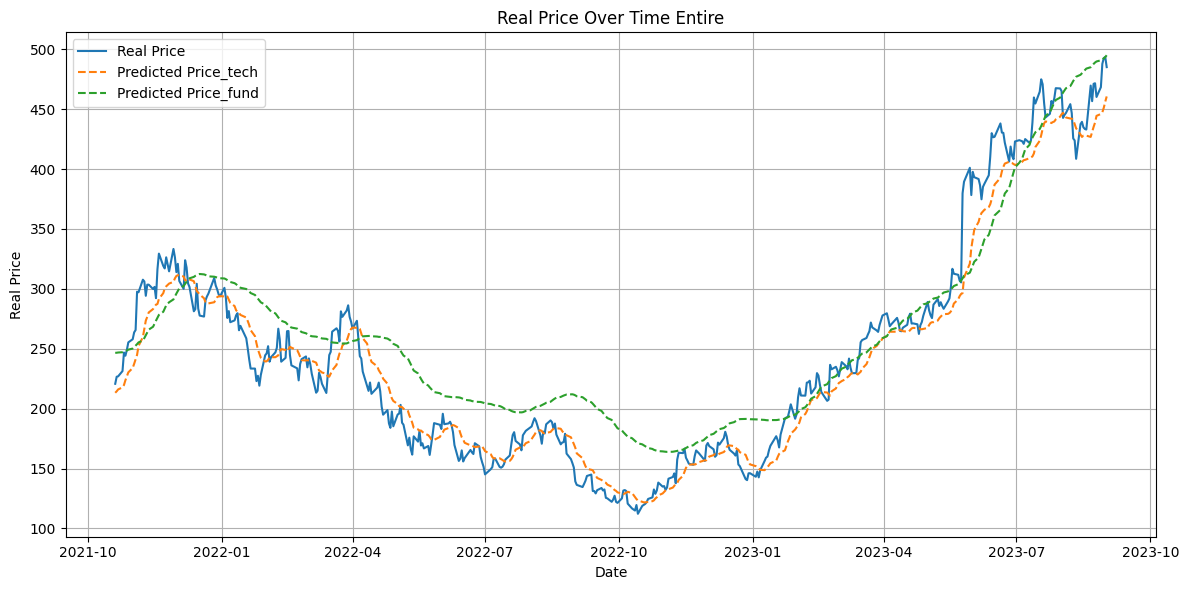

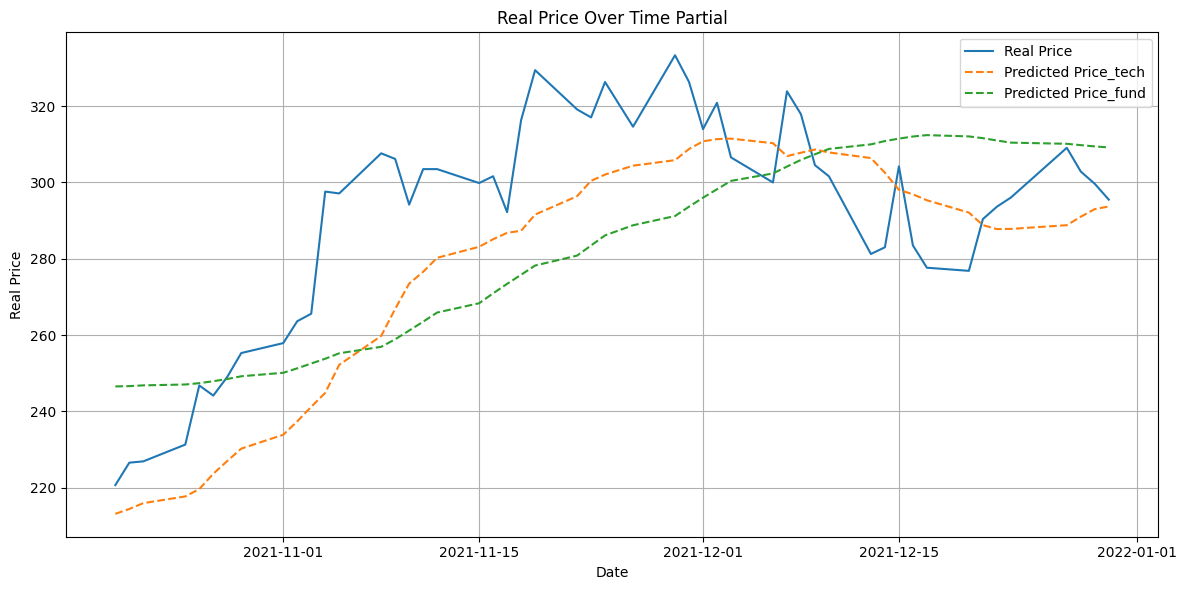

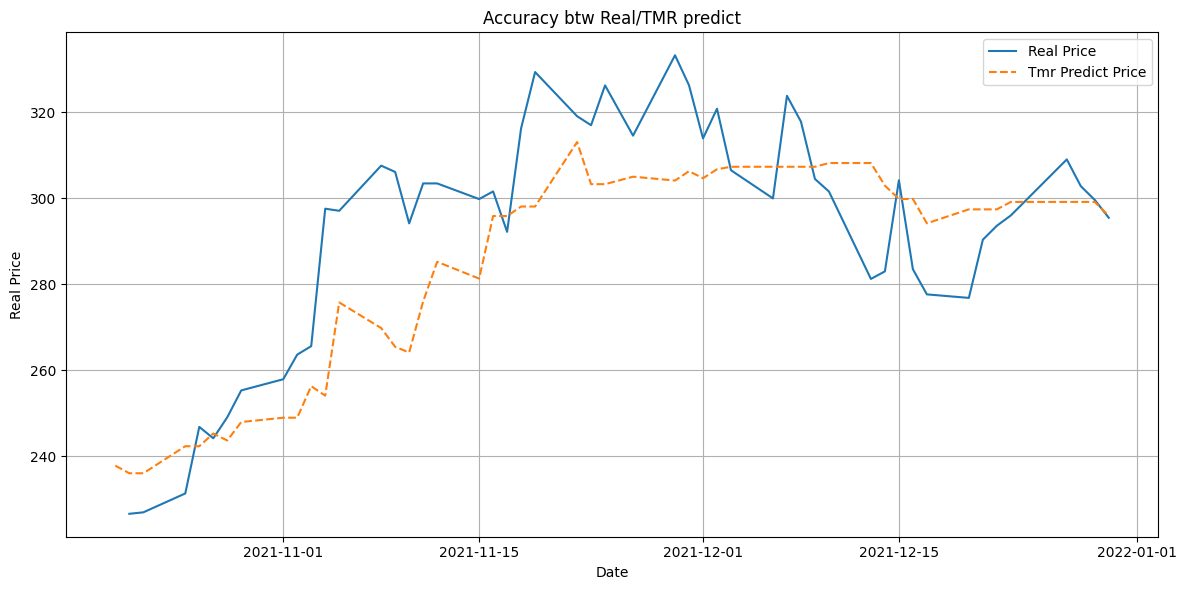

In [9]:
# Plotting 1
plt.figure(figsize=(12, 6))
plt.plot(final_df['Date'], final_df['Real Price'], linestyle='-', label='Real Price')
plt.plot(final_df['Date'], final_df['Predicted Price_tech'], linestyle='--', label='Predicted Price_tech')
plt.plot(final_df['Date'], final_df['Predicted Price_fund'], linestyle='--', label='Predicted Price_fund')
plt.title('Real Price Over Time Entire')
plt.xlabel('Date')
plt.ylabel('Real Price')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Plotting 2
plt.figure(figsize=(12, 6))
plt.plot(final_df2['Date'], final_df2['Real Price'], linestyle='-', label='Real Price')
plt.plot(final_df2['Date'], final_df2['Predicted Price_tech'], linestyle='--', label='Predicted Price_tech')
plt.plot(final_df2['Date'], final_df2['Predicted Price_fund'], linestyle='--', label='Predicted Price_fund')
plt.title('Real Price Over Time Partial')
plt.xlabel('Date')
plt.ylabel('Real Price')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Plotting 3
plt.figure(figsize=(12, 6))
plt.plot(final_df2['Date'][1:], final_df2['Real Price'][1:], linestyle='-', label='Real Price')
plt.plot(final_df2['Date'], final_df2['Tmr_Predicted'], linestyle='--', label='Tmr Predict Price')
plt.title('Accuracy btw Real/TMR predict')
plt.xlabel('Date')
plt.ylabel('Real Price')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

1. 골크 뽑기

In [4]:
cross_periods = []
crossing_golden = False
cross_start_date = None
days_for_cross = 1  # 30일 동안 지속되어야 함

for i in range(1, len(final_df) - days_for_cross):
    tech_price = final_df['Predicted Price_tech'].iloc[i]
    fund_price = final_df['Predicted Price_fund'].iloc[i]
    prev_tech_price = final_df['Predicted Price_tech'].iloc[i-1]
    prev_fund_price = final_df['Predicted Price_fund'].iloc[i-1]

    next_tech_prices = final_df['Predicted Price_tech'].iloc[i+1:i+days_for_cross]
    next_fund_prices = final_df['Predicted Price_fund'].iloc[i+1:i+days_for_cross]

    # Detect possible start of a Golden Cross
    if tech_price > fund_price and prev_tech_price <= prev_fund_price:
        if all(tech > fund for tech, fund in zip(next_tech_prices, next_fund_prices)):  # 3 days of tech > fund
            crossing_golden = True
            cross_start_date = final_df['Date'].iloc[i]

    # Detect Dead Cross
    if tech_price < fund_price and crossing_golden:
        cross_end_date = final_df['Date'].iloc[i]
        cross_periods.append({"Start": cross_start_date, "End": cross_end_date})
        crossing_golden = False

if crossing_golden:  # If Golden Cross persists till the end
    cross_periods.append({"Start": cross_start_date, "End": "Still in Golden Cross"})

for period in cross_periods:
    print("Golden Start:", period["Start"], "| Dead Start:", period["End"])


Golden Start: 2021-11-18 00:00:00 | Dead Start: 2022-12-28 00:00:00
Golden Start: 2023-01-11 00:00:00 | Dead Start: Still in Golden Cross


2. 1프로 이득전망 구매 1프로 이득 판매 1프로 손해 손절

In [10]:
def simulate_trading_corrected(df, start_date, end_date):
    # Initial values
    cash = 1000
    shares = 0
    purchase_price = None

    # Filtering the dataframe based on the start and end date
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

    # Creating columns for simulation results
    df['Action'] = 'hold'
    df['Shares'] = 0
    df['Trade Volume'] = 0.0
    df['Cash'] = cash

    for i in range(len(df) - 1):  # -1 because we're comparing with the next day's prediction
        today_actual = df.iloc[i]['Real Price']
        tomorrow_predicted = df.iloc[i]['Tmr_Predicted']

        # Buy condition: If tomorrow's predicted price is > 1% of today's actual price, we have cash, and we can afford at least one share
        if tomorrow_predicted > today_actual * 1.02 and cash > 0 and cash >= today_actual:
            shares_bought = cash // today_actual
            cash -= shares_bought * today_actual

            shares += shares_bought
            purchase_price = today_actual

            df.iloc[i, df.columns.get_loc('Action')] = 'buy'
            df.iloc[i, df.columns.get_loc('Shares')] = shares_bought
            df.iloc[i, df.columns.get_loc('Trade Volume')] = shares_bought * today_actual
            df.iloc[i, df.columns.get_loc('Cash')] = cash

        # Sell condition: If today's actual price is > 1% of purchase price and we have shares
        elif purchase_price and today_actual > purchase_price * 1.02 and shares > 0:
            cash += shares * today_actual

            shares_sold = shares  # Selling all shares
            shares = 0
            purchase_price = None

            df.iloc[i, df.columns.get_loc('Action')] = 'sell'
            df.iloc[i, df.columns.get_loc('Shares')] = -shares_sold
            df.iloc[i, df.columns.get_loc('Trade Volume')] = -shares_sold * today_actual
            df.iloc[i, df.columns.get_loc('Cash')] = cash

        # Hold condition: No action, just update the cash column
        else:
            df.iloc[i, df.columns.get_loc('Cash')] = cash

    # For the last day, if we still have shares, we sell them
    if shares > 0:
        cash += shares * df.iloc[-1]['Real Price']
        df.iloc[-1, df.columns.get_loc('Action')] = 'sell'
        df.iloc[-1, df.columns.get_loc('Shares')] = -shares
        df.iloc[-1, df.columns.get_loc('Trade Volume')] = -shares * df.iloc[-1]['Real Price']
    
    df.iloc[-1, df.columns.get_loc('Cash')] = cash  # Correctly updating cash on the last day
    df.drop(columns=['Predicted Price_tech', 'Predicted Price_fund','Unnamed: 0'], inplace=True)
    return df


# 실행
result_df = simulate_trading_corrected(final_df,start_date=start_date, end_date=end_date)
print(result_df)

         Date  Real Price  Tmr_Predicted  Accuracy Percentage Action  Shares  \
0  2021-10-20  220.717957     237.799324            95.057508    buy       4   
1  2021-10-21  226.599655     236.030051            95.994116   sell      -4   
2  2021-10-22  226.939133     236.030051            97.969562    buy       4   
3  2021-10-25  231.332977     242.319301            98.176110   hold       0   
4  2021-10-26  246.821045     242.319301            99.244154   sell      -4   
5  2021-10-27  244.164810     245.280781            98.483447   hold       0   
6  2021-10-28  249.057877     243.651930            95.434108   hold       0   
7  2021-10-29  255.309067     247.953164            96.141131   hold       0   
8  2021-11-01  257.905396     248.958093            94.432045   hold       0   
9  2021-11-02  263.637299     248.958093            93.732626   hold       0   
10 2021-11-03  265.604523     256.300148            86.125451   hold       0   
11 2021-11-04  297.589325     254.088968

3. 골크데크에 따른 10프로 매매법

In [6]:
def trade_simulation(final_df, cross_periods, start_date, end_date):
    cash = 1000.0
    stocks = 0
    buy_price = 0  # 주식을 산 가격
    results = []
    sell_next_day = False  # 10% 이상 오르면 다음날 팔아야 하는 상태

    # 데이터프레임을 start_date와 end_date 사이로 필터링
    filtered_df = final_df[(final_df['Date'] >= start_date) & (final_df['Date'] <= end_date)]

    for i, row in filtered_df.iterrows():
        date = row['Date']
        real_price = row['Real Price']
        action = 'hold'
        trade_volume = 0
        
        # 매일의 가격과 날짜를 체크하면서 골든/데드 크로스와 일치하는지 확인
        if date in [period["Start"] for period in cross_periods] and cash >= real_price:
            stocks_bought = int(cash / real_price)
            trade_volume = stocks_bought * real_price
            cash -= trade_volume
            stocks += stocks_bought
            action = 'buy'
            buy_price = real_price
                
        # 주가가 구매가격 대비 10% 이상 오르면 다음날 팔도록 상태 설정
        if stocks > 0 and real_price >= 1.10 * buy_price:
            sell_next_day = True
            
        # 설정된 상태에 따라 다음날 판매
        if sell_next_day and stocks > 0:
            trade_volume = stocks * real_price
            cash += trade_volume
            stocks = 0
            action = 'sell'
            buy_price = 0
            sell_next_day = False

        # 결과 데이터프레임을 위한 행 추가
        results.append({
            "Date": date,
            "Real Price": real_price,
            "Tmr_Predicted": row['Tmr_Predicted'],
            "Accuracy Percentage": row['Accuracy Percentage'],
            "Action": action,
            "Shares": stocks,
            "Trade Volume": trade_volume,
            "Cash": cash
        })

    # 결과 데이터프레임 생성
    results_df = pd.DataFrame(results)
    return results_df

# 실행
result_df = trade_simulation(final_df, cross_periods, start_date=start_date, end_date=end_date)
print(result_df)


          Date  Real Price  Tmr_Predicted  Accuracy Percentage Action  Shares  \
0   2021-10-20  147.552902     144.051306            97.483204   hold       0   
1   2021-10-21  147.770386     143.855699            97.868039   hold       0   
2   2021-10-22  146.989456     147.216763            99.811671   hold       0   
3   2021-10-25  146.940033     146.597619            99.312631   hold       0   
4   2021-10-26  147.612259     147.231090            99.943270   hold       0   
..         ...         ...            ...                  ...    ...     ...   
465 2023-08-28  180.190002     184.159686            99.978443   hold       0   
466 2023-08-29  184.119995     186.359954            99.312529   hold       0   
467 2023-08-30  187.649994     185.878416            98.939916   hold       0   
468 2023-08-31  187.869995     184.590879            97.429997   hold       0   
469 2023-09-01  189.460007     183.629298                  NaN   hold       0   

     Trade Volume         C